## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Loading the dataset

In [2]:
# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    

IMAGES_DIR = '../dataset/Garbage classification/Garbage classification'
    
train_file = '../dataset/one-indexed-files-notrash_train.txt'
val_file   = '../dataset/one-indexed-files-notrash_val.txt'
test_file  = '../dataset/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])

df_train = add_class_name_prefix(df_train, 'path')
df_valid = add_class_name_prefix(df_valid, 'path')
df_test  = add_class_name_prefix(df_test,  'path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 328 samples.


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\fangw\AppData\Local\Temp\ipykernel_11348\267473665.py:3: SyntaxWarning: invalid escape sequence '\d'
  df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)


## Image Preprocessing

In [3]:
# ImageDataGenerator: For data preprocessing
# flow_from_dataframe: Takes the Pandas DataFrame and the path to a directory and generates batches of augmented/normalized data

gen = ImageDataGenerator(rescale=1./255)    # rescaling the images between 0 and 1

gen_train = gen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

gen_valid = gen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

test_gen = gen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


## Model

In [4]:
# Function defining model architecture

def build_model(num_classes):
    # Loading pre-trained ResNet model
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    base_model.trainable = False
        
    return model

model = build_model(num_classes=6)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [5]:
# Model training

history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=10 # 30
)

Epoch 1/10


C:\Users\fangw\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - categorical_accuracy: 0.3388 - loss: 1.5526 - val_categorical_accuracy: 0.5244 - val_loss: 1.1588
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - categorical_accuracy: 0.6056 - loss: 1.0544 - val_categorical_accuracy: 0.6616 - val_loss: 0.9655
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - categorical_accuracy: 0.6727 - loss: 0.9155 - val_categorical_accuracy: 0.6890 - val_loss: 0.8617
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - categorical_accuracy: 0.6952 - loss: 0.8358 - val_categorical_accuracy: 0.6951 - val_loss: 0.8224
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - categorical_accuracy: 0.7316 - loss: 0.7353 - val_categorical_accuracy: 0.6585 - val_loss: 0.8817
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - categorical_accuracy: 0.7475 - loss: 0.6965 - val_categorical_accuracy: 0.7348 - val_loss: 0.7548
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - categorical_accuracy: 0.7721 - loss: 0.6442 - val_ca

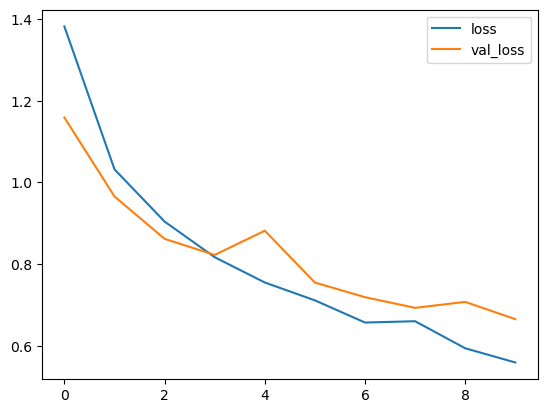

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

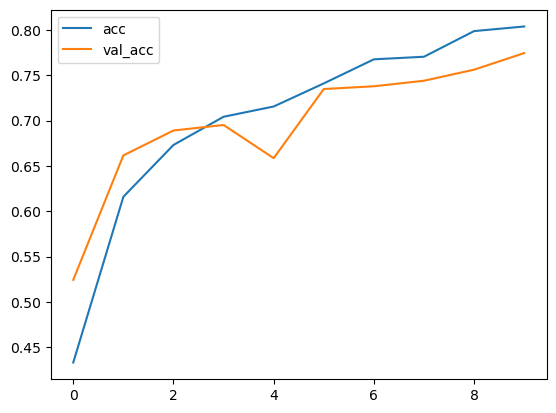

In [7]:
plt.plot(history.history['categorical_accuracy'], label='acc')
plt.plot(history.history['val_categorical_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Evaluating

In [9]:
# Evaluating the model on test data

filenames = test_gen.filenames
nb_samples = len(filenames)

model.evaluate(test_gen, steps=nb_samples)

328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - categorical_accuracy: 0.7754 - loss: 0.6644


C:\Users\fangw\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.6651769280433655, 0.7743902206420898]

In [10]:
# Generating predictions on test data

test_x, test_y = test_gen.__getitem__(1)
preds = model.predict(test_x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


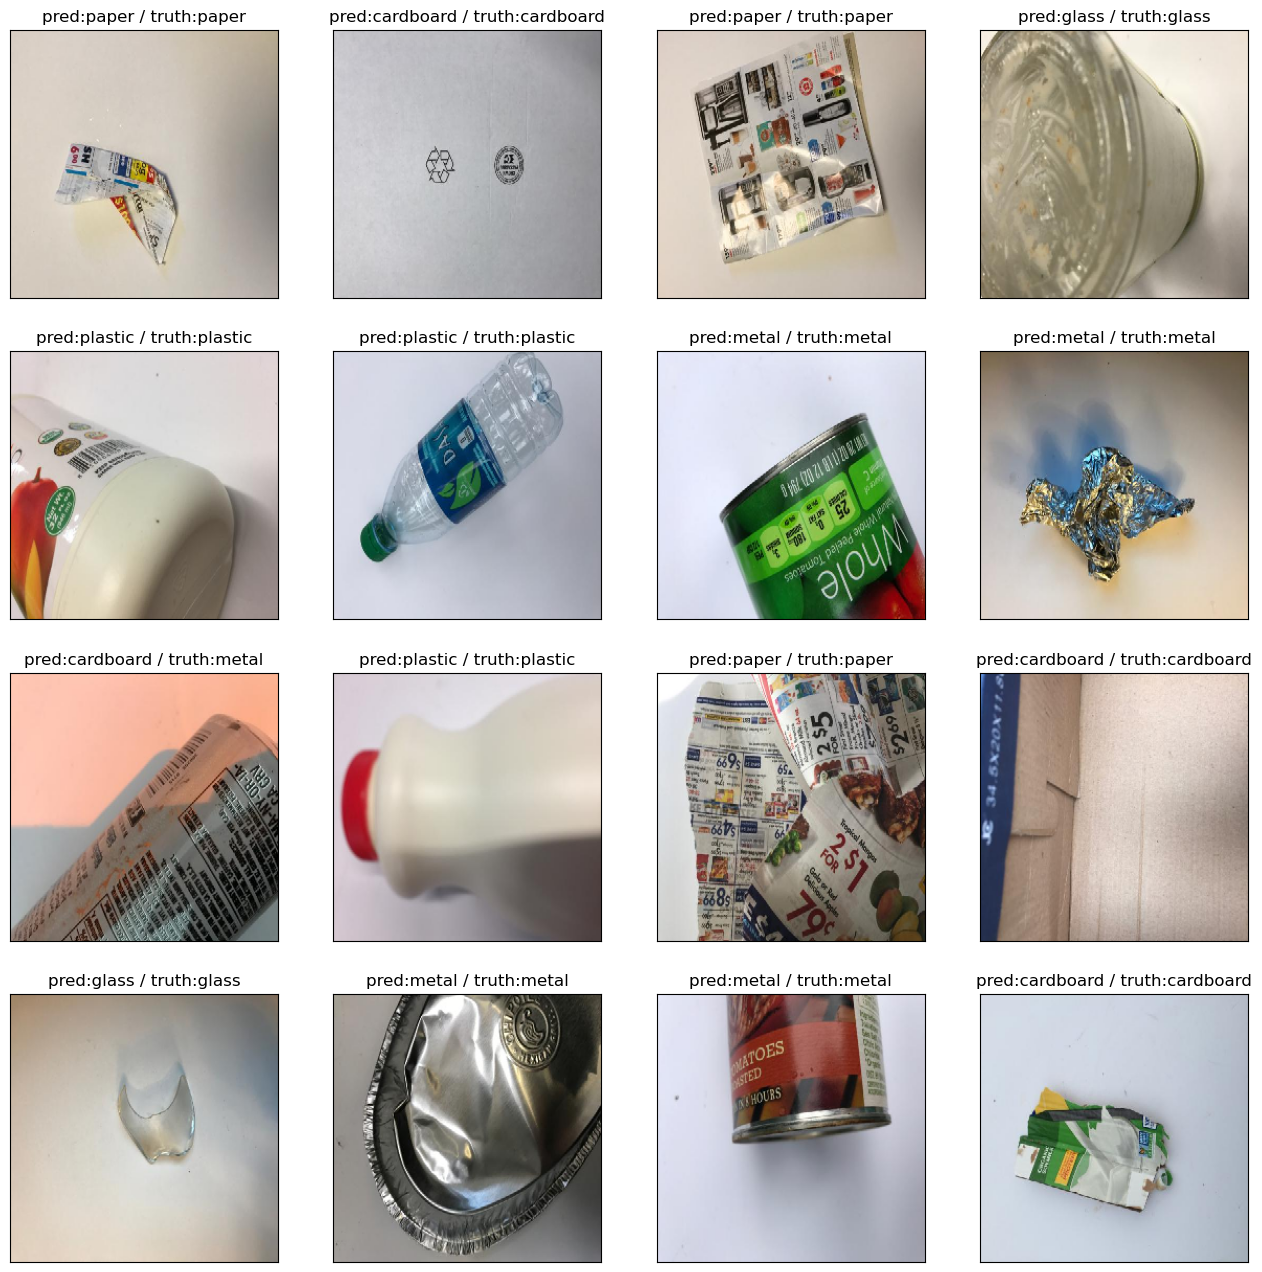

In [11]:
# Comparing predcitons with original labels

labels = (gen_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Confusion Matrix


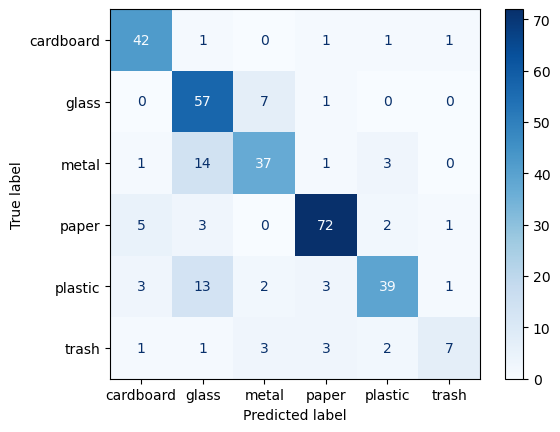

In [12]:
# Confusion Matrix

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [13]:
# Accuracy

acc = accuracy_score(test_gen.classes, y_pred)
print("Accuracy is {} percent".format(round(acc*100,2)))

Accuracy is 77.44 percent


## 保存模型

In [15]:
model.save("model_vgg16.keras")
print("saved!")

saved!
